In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lng
import subprocess
import os
import struct
import time

# Download and unzip

In [ ]:
## DON'T RUN ME MORE THAN ONCE
# downloading and formatting the data
# training set images (9912422 bytes), training set labels, test images, test labels
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']
for url in urls:
    print(url)
    subprocess.run(['wget', url])
print('done')
## ALSO ONLY RUN ME ONCE
files = []
path = '/Users/audrey_der/Documents/Spring 2020/EECS260/hw1'
for i,file in enumerate(os.listdir(path)):
    if file.endswith(".gz"):
        print(file)
        files.append(os.path.basename(file))
        subprocess.run(['gzip', '-d', file])

In [2]:
#time to do minibatch sgd
def minibatch_SGD(B, itrs, eta, train_x, train_y, x_test, y_test):
    weights = []
    loss = []
    te_loss =[]
    tr_err_list = []
    te_err_list = []
    W = np.zeros((784,10), dtype=np.float32)
    for i in range(itrs):
        if i % 250 == 0:
            print("Num iters: {}".format(i))
        # select batch
        r = np.random.choice(len(train_x), size=B, replace=False)
        X = train_x[r,:]
        Y = train_y[r,:]
        g = X.T.dot(X.dot(W)) - X.T.dot(Y)
        g /= B
        W  -= eta*(g)
        weights.append(W)
        loss.append(0.5*np.square(lng.norm((Y - X.dot(W)),'fro'))/B)
#         loss.append(.5*np.square(lng.norm((y_test - x_test.dot(W)),'fro'))/y_test.shape[0])
        
        tr_err = 1-((np.argmax(train_x@W, axis=1) == np.argmax(train_y,axis=1)).sum() / y.shape[0])
        te_err = 1-((np.argmax(x_test@W, axis=1) == np.argmax(y_test,axis=1)).sum())/y_test.shape[0]       
        tr_err_list.append(100*tr_err)
        te_err_list.append(100*te_err)
        
    return weights, loss, te_err_list, tr_err_list

def mse(y_hat,y):
    return 0.5*np.square(lng.norm((y - y_hat),'fro'))

def agg_weights(train_x,train_y, x_test, y_test):
    batches = [1, 10, 100, 1000]
    L = []
    TT = []
    weights_at = []
    L_test = []
    test_err_rate = []
    train_err_rate = []
    for b in range(len(batches)): 
        l_te = []
        print("Training batch size: {}".format(b))
        start_time = time.time()
        W, loss, te_err_list, tr_err_list = minibatch_SGD(batches[b],1000,10**-9,train_x,train_y, x_test, y_test) # W: array of weights at each itr
        TT.append(time.time() - start_time)
        L.append(loss)
        test_err_rate.append(te_err_list)
        train_err_rate.append(tr_err_list)
        for w in W:
            l_te.append((0.5*np.square(lng.norm((y_test - x_test.dot(w)),'fro')))/10000)
        print("################")
        L_test.append(l_te)
        
    return L, TT, L_test, train_err_rate, test_err_rate

# Read Data

In [3]:
def readImages(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        rows, cols = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.astype(np.float32)
        data = data.reshape((size, rows * cols))
    return data

def readLabels(file):
    with open(file.split('.')[0], 'rb') as f:
        magic_num, size = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(),dtype=np.dtype(np.uint8).newbyteorder(">"))
        data = data.reshape((size))
    data_ohe = np.zeros((data.shape[0], data.max()+1))
    data_ohe[np.arange(data.shape[0]), data] = 1
    return data_ohe

x = readImages('train-images-idx3-ubyte')
y = readLabels('train-labels-idx1-ubyte')
x_test = readImages('t10k-images-idx3-ubyte')
Y_test = readLabels('t10k-labels-idx1-ubyte')

In [44]:
# print(x_test.shape)
# print(Y_test.max(axis=1))
# print(np.argmax(Y_test,axis=1))

(10000, 784)
[5 0 4 ... 6 9 7]


In [4]:
L, TT, L_test, misclass_tr, misclass_te = agg_weights(x,y,x_test,Y_test)

Training batch size: 0
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
################
Training batch size: 1
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
################
Training batch size: 2
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
################
Training batch size: 3
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
################


In [5]:
# fig = plt.figure(figsize=(18,18))
# plt.plot([i for i in range(1000)], misclass_tr[0])
# plt.plot([i for i in range(1000)], misclass_te[0])

# plt.plot([i for i in range(1000)], L_test[0])
# print(misclass_te[0])
# print()
print(TT)

[22.83159112930298, 23.12595510482788, 24.037477016448975, 25.498070001602173]


/Users/audrey_der/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


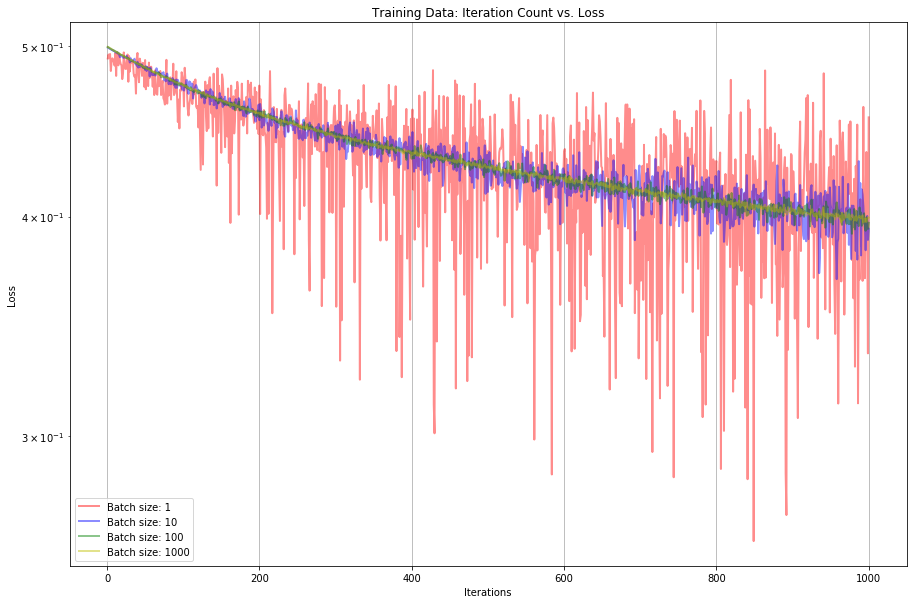

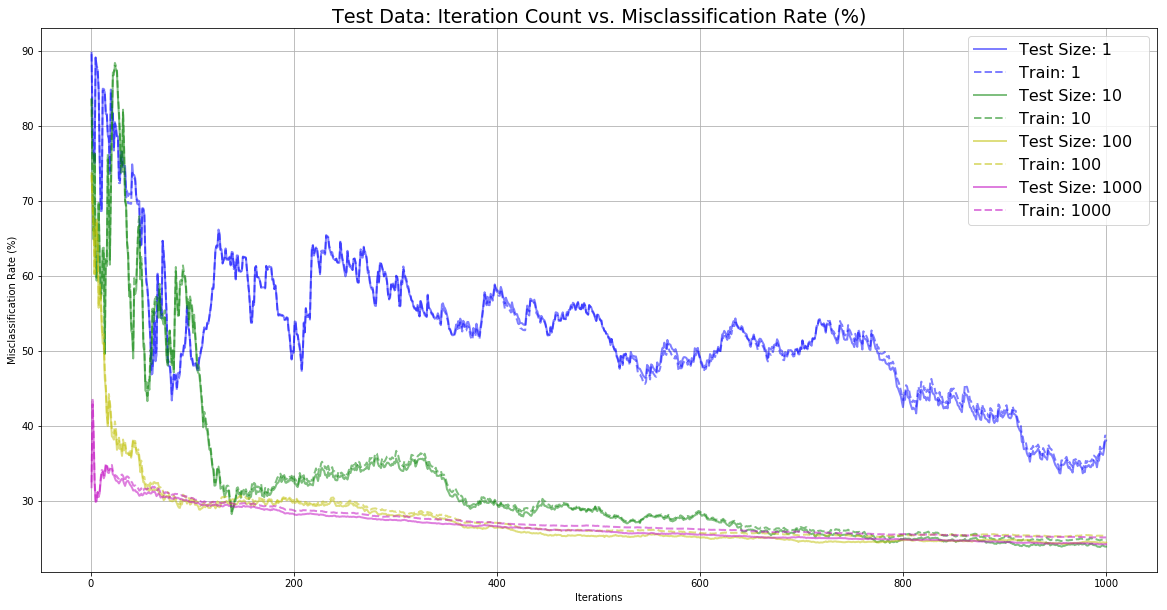

In [6]:
f, axs = plt.subplots(1,1,figsize=(15,10))
colors = ['r', 'b', 'g', 'y', 'm', 'k']
x_plot = np.linspace(1,1000,num=1000)
j = 0
batches = [1,10,100,1000]
for b in range(len(batches)): 
    plt.subplot(1, 1, 1)
    plt.plot(x_plot, L[b], alpha=0.45, color=colors[j], linewidth=2, label="Batch size: {}".format(batches[b]))
    j += 1
    plt.yscale('log')
    plt.grid(True, axis='both', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training Data: Iteration Count vs. Loss')
    plt.legend()
plt.savefig('part3',dpi=300)
plt.show()


f, axs = plt.subplots(1,1,figsize=(20,10))
plt.rcParams.update({'font.size': 16})
colors = ['r', 'b', 'g', 'y', 'm', 'k']
x_plot = np.linspace(1,1000,num=1000)
j = 0
for i in range(4):
    j += 1
    plt.plot(x_plot, misclass_te[i], alpha=0.5, color=colors[j], linewidth=2, label="Test Size: {}".format(batches[i])) # one line per eta
    plt.plot(x_plot, misclass_tr[i], alpha=0.5, color=colors[j], linestyle='--',linewidth=2, label="Train: {}".format(batches[i])) # one line per eta
    plt.grid(True, axis='both', linestyle='-')
    plt.xlabel('Iterations')
    plt.ylabel('Misclassification Rate (%)')
    plt.title('Test Data: Iteration Count vs. Misclassification Rate (%)')
    plt.legend()
plt.savefig('part3_test', dpi=300)
plt.show()

In [ ]:
def part5(train_x, train_y, x_test, y_test):
    N = [100,500,1000,10000]
    weights, loss, te_err_list, tr_err_list = [], [], [], []
    for n in range(4):
        idx = np.random.choice(len(x), size=N[n], replace=False)
        X = train_x[idx,:]
        Y = train_y[idx,:]
        w, l, te_err, tr_err = minibatch_SGD(100, 1000, 10**-10, X, Y, x_test, y_test)
        weights.append(w)
        loss.append(l)
        te_err_list.append(te_err)
        tr_err_list.append(tr_err)
    return weights, loss, tr_err_list, te_err_list

weights, loss, tr_err_list, te_err_list = part5(x, y, x_test, Y_test)



Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
Num iters: 0
Num iters: 250
Num iters: 500
Num iters: 750
Num iters: 0
Num iters: 250


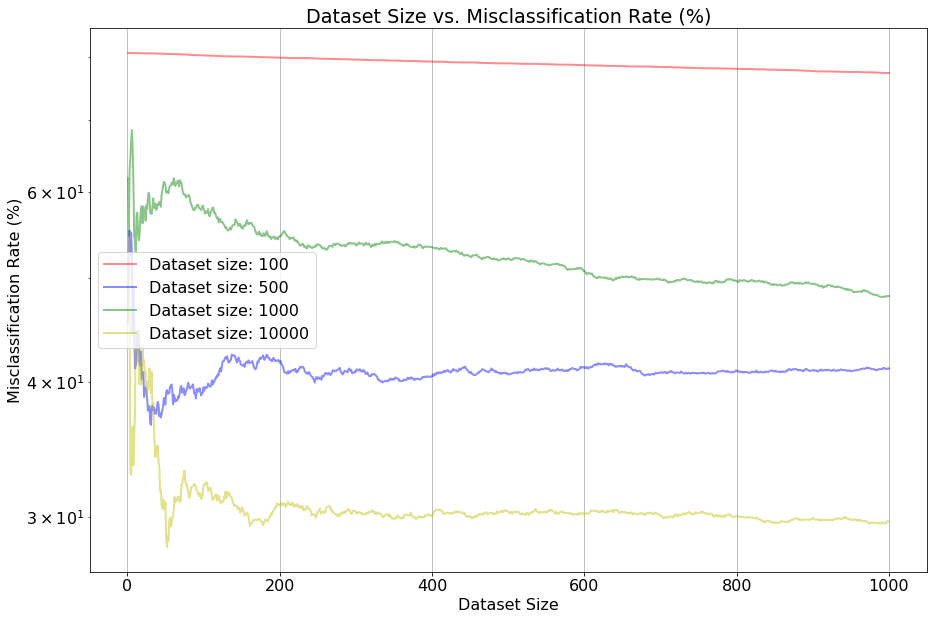

In [25]:
f, axs = plt.subplots(1,1,figsize=(15,10))
colors = ['r', 'b', 'g', 'y', 'm', 'k']
x_plot = np.linspace(1,1000,num=1000)
j = 0
N = [100,500,1000,10000]
plt.subplot(1, 1, 1)
for n in range(4):
    plt.plot(x_plot, te_err_list[n], alpha=0.45, color=colors[j], linewidth=2, label="Dataset size: {}".format(N[n]))
#     plt.plot(x_plot, tr_err_list[n], alpha=0.45, color=colors[j], linestyle='--',linewidth=2, label="Dataset size: {}".format(N[n]))
    j += 1
    plt.yscale('log')
    plt.grid(True, axis='both', linestyle='-')
    plt.xlabel('Dataset Size')
    plt.ylabel('Misclassification Rate (%)')
    plt.title('Dataset Size vs. Misclassification Rate (%)')
plt.legend()
plt.savefig('part5',dpi=300)
plt.show()